<a href="https://colab.research.google.com/github/Ignacio-Ibarra/Approximate-String-Matching/blob/main/TFIDF_String_Matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [90]:
#Paquetes Básicos
import pandas as pd
import numpy as np
import random
import os
import time
import matplotlib.pyplot as plt
from functools import reduce
 
#NLP 
import nltk
import re
import string
import unicodedata
from sklearn.feature_extraction.text import TfidfVectorizer
!pip install sparse_dot_topn
from scipy.sparse import csr_matrix
import sparse_dot_topn.sparse_dot_topn as ct
 
#Montando Drive en la Session de Google Colab
from google.colab import drive 
drive.mount("/content/drive")
 
#Displaying options
pd.set_option("max_colwidth", 60)
 
#RUTA DATASET 
DIRTY_NAMES = '/content/drive/MyDrive/base importadores/outputs/sucios_a_first_cleaning/sucios_a_first_cleaning17_06_21.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# TFIDF

In [92]:
dirty_company_names = pd.read_csv(DIRTY_NAMES)
dirty_company_names = dirty_company_names[dirty_company_names.first_cleaning!="Se borró nombre en limpieza"].reset_index(drop=True)

In [93]:
first_cleaning = dirty_company_names.first_cleaning.unique().tolist()

## N-gramas y palabras comunes

Vectorizo por n-gramas (n=3) y las palabras más comunes las vectorizo como palabras y no como N-gramas. 

In [98]:
from collections import Counter

def get_corpus_splitted(serie): 
  text = " ".join(serie)
  return re.findall(r'\b\S+\b', text)

def wordcount_df_from_serie(serie): 
  counter = Counter()
  text = get_corpus_splitted(serie)
  for word in text:
    counter[word] +=1
  return pd.DataFrame(counter.items(), columns=['word', 'counts']).sort_values(by="counts", ascending=False)

In [99]:
word_count = wordcount_df_from_serie(first_cleaning)

In [155]:
word_count.count

,word,counts
175666,GRAMKOW,1
175667,AKTIVE,1
175668,CANBORN,1
175669,KYUYUU,1
175670,RENOBAT,1


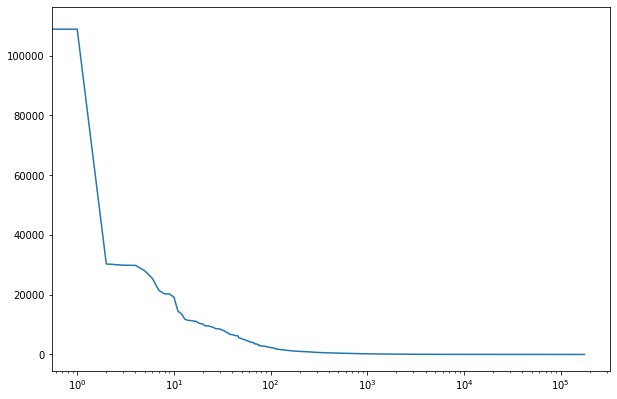

In [100]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10,6.7)
fig, ax = plt.subplots()

barplot = word_count

words = barplot.word.to_numpy()
x_pos = np.arange(len(words))
counts = barplot.counts

ax.plot(x_pos, counts)
plt.yscale('linear')
plt.xscale('log')
# ax.set_xticks(x_pos)
# ax.set_xticklabels(words, rotation=90)
#ax.invert_xaxis()  # labels read top-to-bottom
# ax.set_ylabel('Quantity')
# ax.set_title('Most Common Words')

plt.show()

In [101]:
len(word_count[word_count.counts>1030])

197

In [102]:
TOPNCOMMON = 197 #aparece HUAWEI en el lugar 198
common_words = word_count.iloc[:TOPNCOMMON,:].word.to_list()

In [103]:
common_words.remove("ABB")

In [104]:
def ngrams(string, n=3): 
    commons = []
    text = []
    for word in string.split(" "):
      if word not in common_words:
        text.append(word)
      else: 
        commons.append(word)
    text = " ".join(text)
    ngrams = zip(*[text[i:] for i in range(n)])
    lista = np.unique([''.join(ngram) for ngram in ngrams]+commons).tolist()
    return lista

## `TfidfVectorizer`

In [105]:
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer(min_df=3, analyzer=ngrams) 
tf_idf_first_cleaning = vectorizer.fit_transform(first_cleaning)


In [106]:
tf_idf_first_cleaning.shape

(520666, 14792)

## `awesome_cossim_topn`

In [107]:
from scipy.sparse import csr_matrix
from sparse_dot_topn import awesome_cossim_topn

import time
t1 = time.time()
matches_ngrams = awesome_cossim_topn(tf_idf_first_cleaning, tf_idf_first_cleaning.transpose(), 200, 0.8)
t = time.time()-t1
print('This program remains {} seconds with ngrams'.format(t))

This program remains 1217.5998668670654 seconds with ngrams


In [108]:
from scipy import sparse

"""
Guardo macheos en un archivo npz porque tarda mucho en correr 
el producto de matrices, porque son muy grandes. Dado que el resultado es determinístico 
no es necesario volver a correrlo nuevamente a menos que cambie 
algún parámetro de la limpieza, del vecotrizador o de la función awesome_cossim_topn
"""

ngrams_filename = '/content/drive/MyDrive/base importadores/outputs/TF-IDF_matches_save/ngrams_matces_csr_saving17_06_2021B.npz'
sparse.save_npz(ngrams_filename, matches_ngrams)

# Para cargar de nuevo la matriz descomentar la siguiente linea. 
matches_ngrams = sparse.load_npz(ngrams_filename)

## Ejemplos de Similares

In [109]:
first_cleaning[0]

'TAKMAY INDUSTRIAL COMPANY LIMITED'

In [110]:
print(matches_ngrams[0,:])

  (0, 0)	1.0
  (0, 450892)	0.9770238834328502
  (0, 203198)	0.9681518484806251
  (0, 78083)	0.9217589977381133
  (0, 285972)	0.8892040291683554
  (0, 12441)	0.8728706342718306
  (0, 462536)	0.8592617212038003
  (0, 178912)	0.8281800393072007


In [111]:
for i in matches_ngrams[0,:].indices: 
  print(first_cleaning[i])

TAKMAY INDUSTRIAL COMPANY LIMITED
TAKMAY INDUSTRIAL COMPANY
TAKMAY INDUSTRIAL COMPANY LTD
TAKMAY INDUSTRIAL CO LTD
TAKMAY INDUSTRIAL CO LTD OP
TAKMAY INDUSTRIAL COLTD OP
TAKMAY IND CO LTD
TAKMAY IND CO LTD OP


In [112]:
print("YA CORRIO TODOOOO")

YA CORRIO TODOOOO


## Obtengo similares

In [114]:
from tqdm import tqdm

massive_dict = {}
for key in tqdm(range(matches_ngrams.shape[0])):
  massive_dict[key] = matches_ngrams[key,:].indices

ya_vistos = {}
grupos = []
for i in tqdm(range(matches_ngrams.shape[0])): 
  if i not in ya_vistos:
    ya_vistos[i]=1
    unicos = massive_dict[i].tolist()
    if len(unicos)>1:
      indices = massive_dict[i][1:]
      for ind in indices:
        if ind not in ya_vistos:
          ya_vistos[ind]=1
          unicos = unicos + massive_dict[ind].tolist()
      unicos = list(set(unicos))
      grupos.append(unicos)
    else: 
      ya_vistos[i]=1
      grupos.append(unicos)

100%|██████████| 520666/520666 [00:03<00:00, 152000.07it/s]


In [115]:
second_cleaning_tfidf = pd.DataFrame(first_cleaning, columns = ['unicos_first_cleaning'])

from tqdm import tqdm
import functools

second_cleaning_tfidf['tfidf_cleaning'] = "no name"
for group in tqdm(grupos): 
  names = second_cleaning_tfidf.iloc[np.array(group, dtype="int64")]['unicos_first_cleaning'].to_list()
  if len(names)>1:
    group_name = functools.reduce(lambda a,b: b if len(a.split(" "))>len(b.split(" ")) else a, names).lstrip().rstrip()
  elif names == []:
    pass
  else:
    group_name = names[0].lstrip().rstrip() 
  second_cleaning_tfidf.iloc[np.array(group, dtype="int64"),1] = group_name

100%|██████████| 295716/295716 [02:18<00:00, 2142.37it/s]


In [154]:
second_cleaning_tfidf.to_csv("/content/drive/MyDrive/base importadores/outputs/tfidf_cleaning/tfidf_cleaning17_06_2021B.csv", index=False)